In [54]:
import json
import pandas as pd
from utils import preprocessing, set_index
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras import models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import clone_model 
from dc_vae_continual import DCVAE, Sampling
from utils import samples_conditions_embedd
import pickle
from statsmodels.graphics.tsaplots import plot_acf

In [16]:
def likelihood_norm(x, mu, sigma):
    return (np.exp(-0.5*((x-mu)/sigma)**2)/(np.sqrt(2*np.pi)*sigma))/(1/(np.sqrt(2*np.pi)*sigma))

### Settings

In [17]:
settings_path = 'settings/model_settings_continual.txt'
settings = json.load(open(settings_path, 'r'))
print(settings)

{'dataset_name': 'TELCO', 'model_name': 'dc-vae_continual', 'scale': False, 'wo_outliers': True, 'max_std': 7, 'T': 128, 'M': 12, 'cnn_units': [64, 128, 128, 128, 128, 128, 64], 'dil_rate': [1, 2, 4, 8, 16, 32, 64], 'kernel': 2, 'strs': 1, 'activation': 'selu', 'alpha_reg': 0.0001, 'batch_size': 32, 'J': 64, 'epochs': 200, 'lr': 0.0001, 'lr_decay': False, 'decay_rate': 0.96, 'decay_step': 7000, 'val_percent': 0.2, 'time_embedding': False, 'summary': True, 'save_best_model': False, 'save_complete_model': True}


### Data

In [18]:
#path = '../../Datasets/TELCO/'
path = "/home/gastong/Documentos/TELCO/v1/" #Rosaluna
filenames_train = ["TELCO_data_2021_11.zip", "TELCO_data_2021_12.zip"]
files_train = [path+ i for i in filenames_train]

# Load data and predictions
# Read CSV files from List
data_train = pd.concat(map(pd.read_csv, files_train))
data_train = set_index(data_train)
data_train = preprocessing(data_train, flag_scaler=False, outliers=True)
data_train.head()

,TS1,TS2,TS3,TS4,TS5,TS6,TS7,TS8,TS9,TS10,TS11,TS12
time,,,,,,,,,,,,
2021-11-01 00:00:00,0.456788,0.361119,0.427533,0.821416,0.440503,0.433320,0.478866,0.482249,0.087843,0.35,0.052165,0.053619
2021-11-01 00:05:00,0.463067,0.361322,0.427533,0.693646,0.448490,0.442270,0.367807,0.393491,0.087843,0.35,0.052165,0.053619
2021-11-01 00:10:00,0.468363,0.340467,0.604864,0.612935,0.402251,0.393046,0.475062,0.446746,0.087843,0.35,0.052165,0.053619
2021-11-01 00:15:00,0.428095,0.327508,0.604864,0.859950,0.337353,0.388198,0.486540,0.467456,0.113067,0.45,0.034588,0.032172
2021-11-01 00:20:00,0.438827,0.326091,0.479911,1.040928,0.430928,0.441524,0.448351,0.434911,0.113067,0.45,0.034588,0.032172


In [19]:
#path = '../../Datasets/TELCO/'
path = "/home/gastong/Documentos/TELCO/v1/" #Rosaluna
filenames = ["TELCO_data_2022_01.zip", "TELCO_data_2022_02.zip", "TELCO_data_2022_03.zip", "TELCO_data_2022_04.zip",
                  "TELCO_data_2022_05.zip", "TELCO_data_2022_06.zip", "TELCO_data_2022_07.zip", "TELCO_data_2022_08.zip", 
                  "TELCO_data_2022_09.zip"]
files = [path+ i for i in filenames]

In [20]:
# Load data and predictions
# Read CSV files from List
data = pd.concat(map(pd.read_csv, files))
data = set_index(data)
data = preprocessing(data, flag_scaler=False, outliers=True)
data.head()

,TS1,TS2,TS3,TS4,TS5,TS6,TS7,TS8,TS9,TS10,TS11,TS12
time,,,,,,,,,,,,
2022-01-01 00:00:00,0.648864,0.505284,0.669942,0.837027,0.623184,0.535870,0.634853,0.668639,0.247535,0.875,0.021380,0.021448
2022-01-01 00:05:00,0.649752,0.497994,0.669942,0.820139,0.580578,0.441524,0.590735,0.582840,0.247535,0.875,0.021380,0.021448
2022-01-01 00:10:00,0.593288,0.476937,0.704539,0.777010,0.643936,0.459797,0.548041,0.520710,0.247535,0.875,0.021380,0.021448
2022-01-01 00:15:00,0.544374,0.467724,0.704539,0.835551,0.570099,0.418404,0.556218,0.523669,0.151931,0.575,0.014328,0.016086
2022-01-01 00:20:00,0.611489,0.443933,0.516019,0.795907,0.523654,0.401623,0.632546,0.588757,0.151931,0.575,0.014328,0.016086


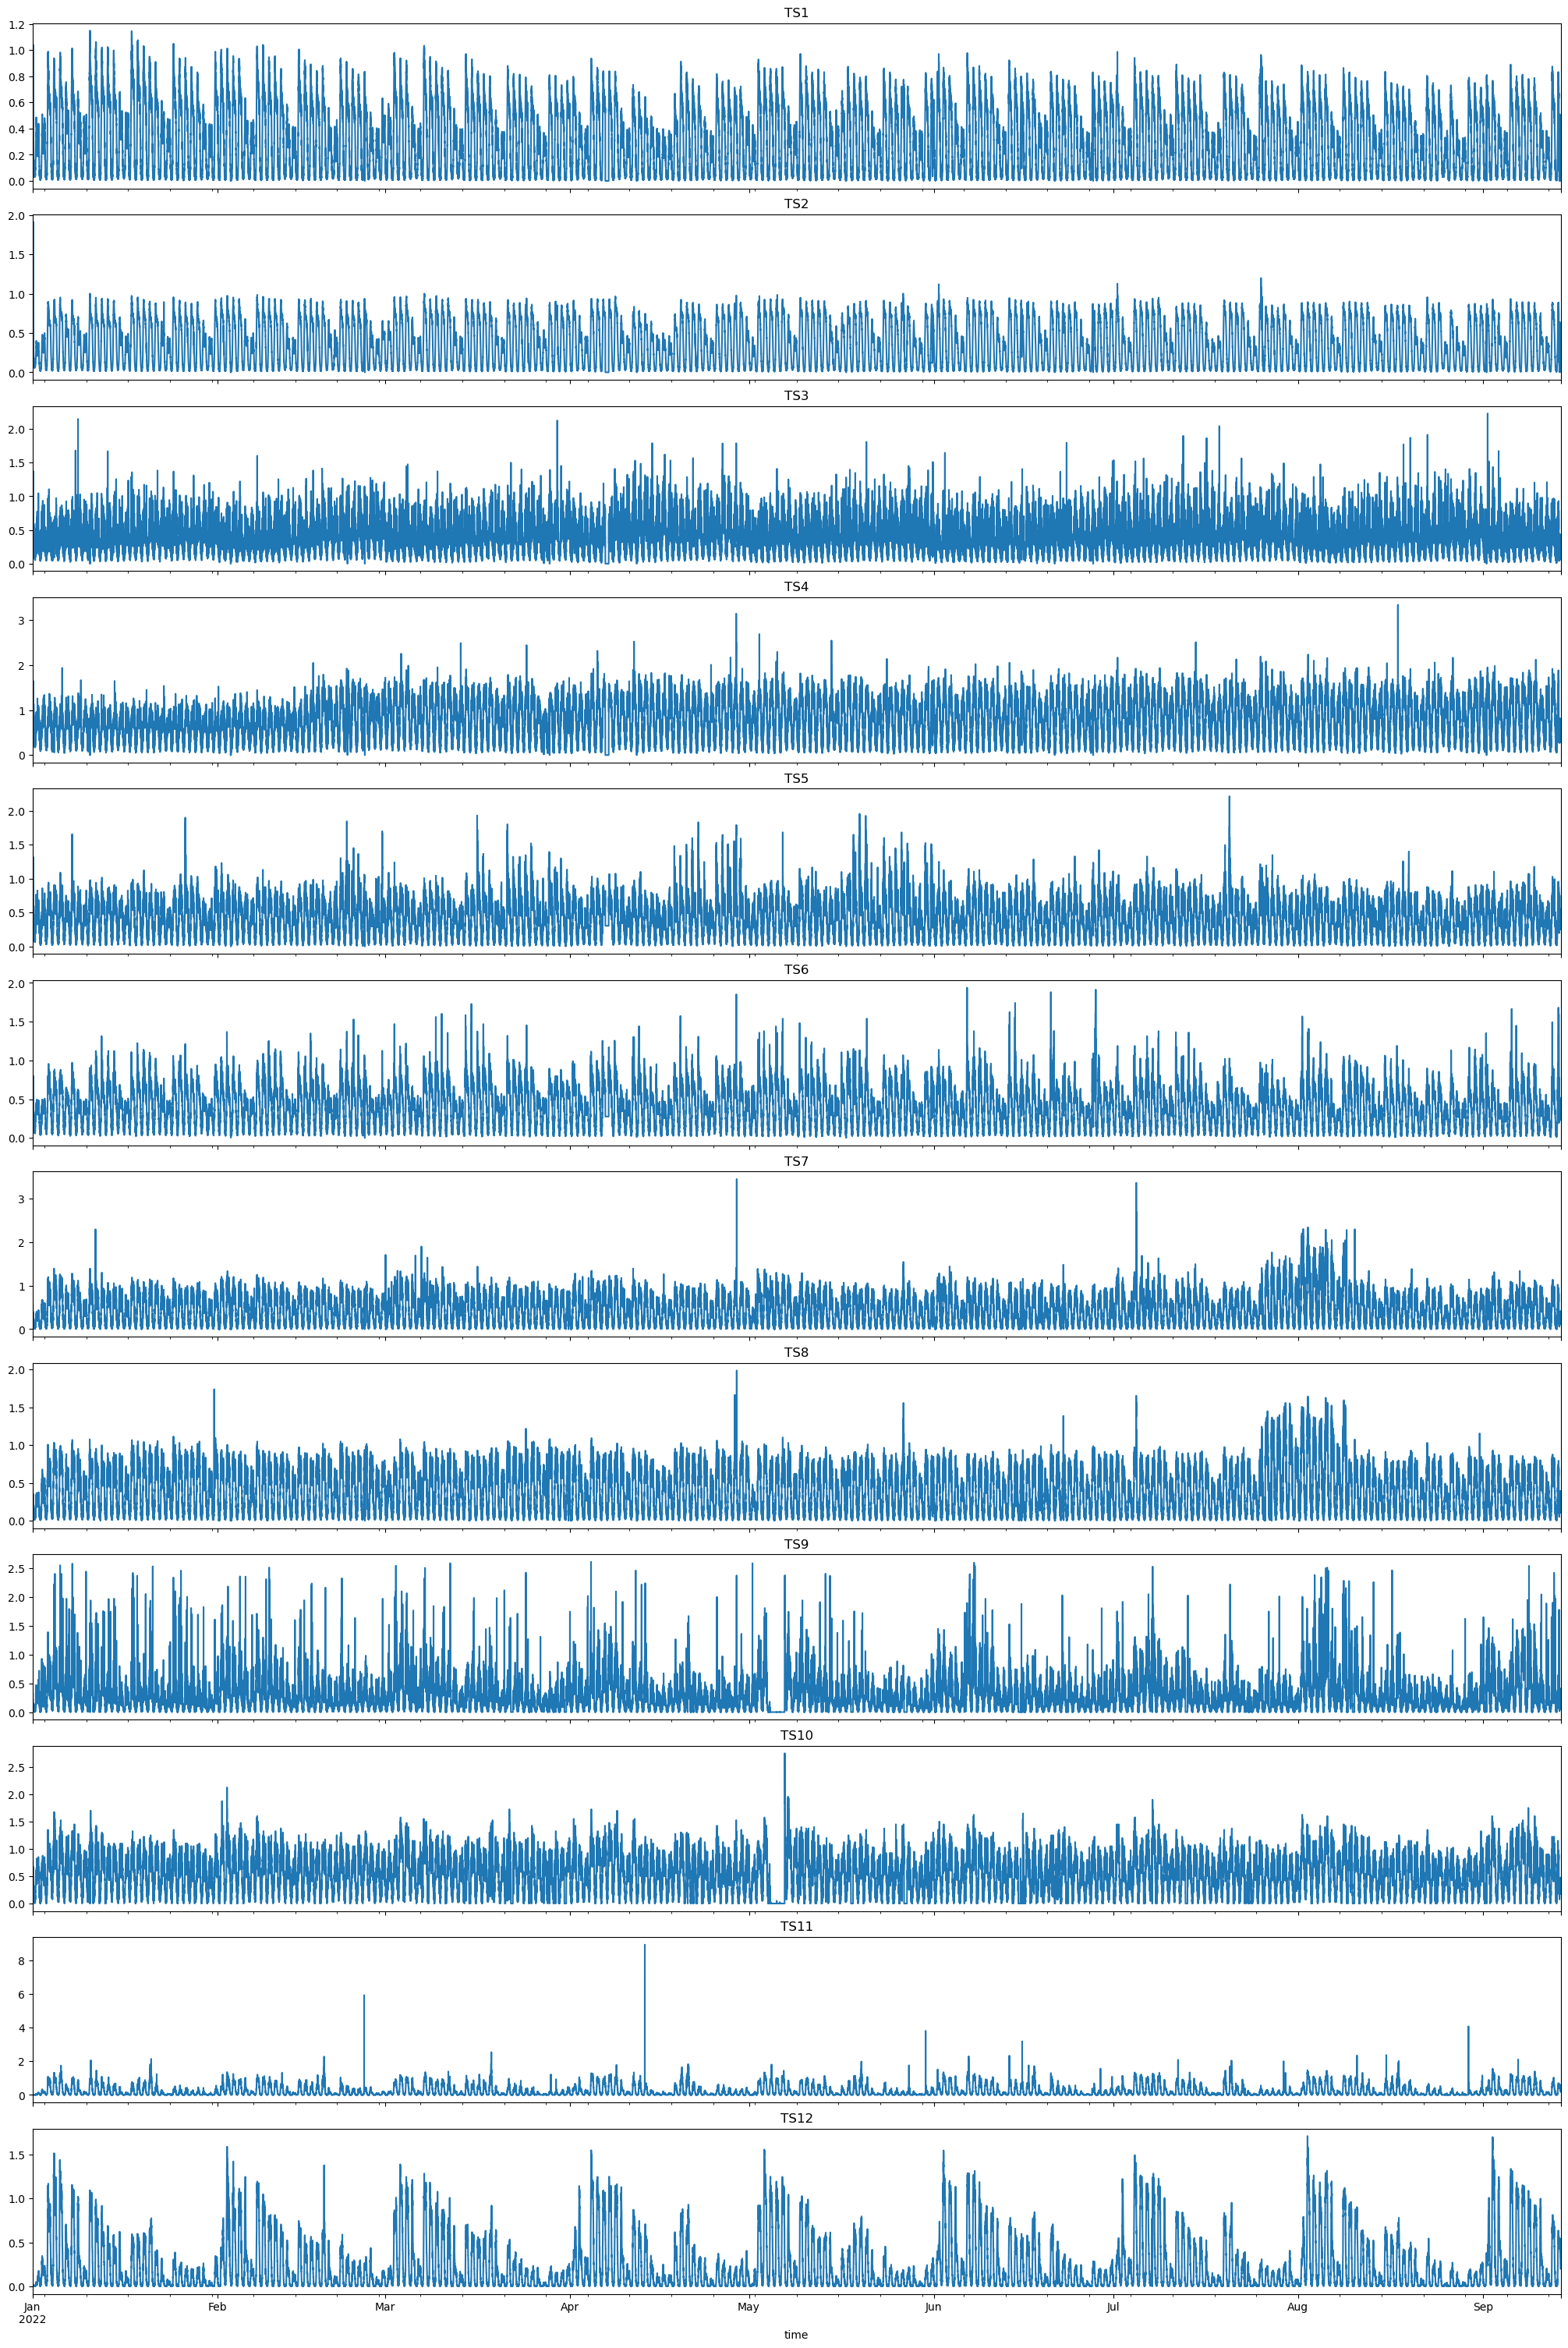

In [21]:
#define number of rows and columns for subplots
nrow=12
ncol=1

columns_list = data.columns

time_start = '2022-01-01'
time_end = '2022-09-13'
fig, axes = plt.subplots(nrow, ncol, figsize=(20,30), constrained_layout=True, sharex=True)

# plot counter
count=0

for r in range(nrow):
    for c in range(ncol):
        data[columns_list[count]][time_start:time_end].plot(ax=axes[r])
        axes[r].set_title(columns_list[count])
        count+=1

### Tada por task

In [22]:
data_train_task1 = data[:'2022-02-28']
data_test_task1 = data['2022-03-01':'2022-03-31']

data_train_task2 = data['2022-04-01':'2022-05-31']
data_test_task2 = data['2022-06-01':'2022-06-30']

data_train_task3 = data['2022-07-01':'2022-08-31']
data_test_task3 = data['2022-09-01':'2022-09-12']

### CD

In [23]:
data_train_task1['TS1'] = 2 * data_train_task1['TS1'] 
data_test_task1['TS1'] = 2 * data_test_task1['TS1'] 

data_train_task2['TS1'] = 3 * data_train_task2['TS1'] 
data_test_task2['TS1'] = 3 * data_test_task2['TS1']  

data_train_task3['TS1'] = 4 * data_train_task3['TS1']  
data_test_task3['TS1'] = 4 * data_test_task3['TS1']  

/tmp/ipykernel_470561/3666605342.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_task1['TS1'] = 2 * data_train_task1['TS1']
/tmp/ipykernel_470561/3666605342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_task1['TS1'] = 2 * data_test_task1['TS1']
/tmp/ipykernel_470561/3666605342.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [24]:
TS1_CD = pd.concat([data_train_task1['TS1'], data_test_task1['TS1'], data_train_task2['TS1'], data_test_task2['TS1'], 
    data_train_task3['TS1'], data_test_task3['TS1']])

<AxesSubplot:xlabel='time'>

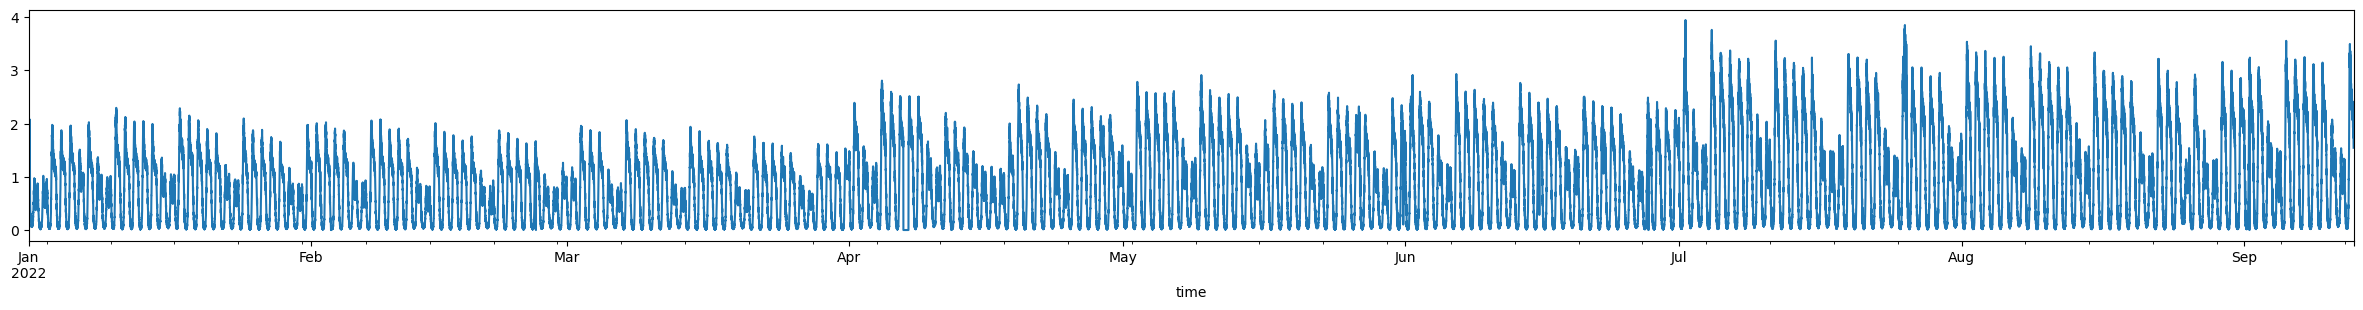

In [25]:
plt.figure(figsize=[30, 3])
TS1_CD.plot()

## Task1

In [35]:
# Model initialization
model_task1 = DCVAE(
    settings['T'],
    settings['M'],
    settings['cnn_units'],
    settings['dil_rate'],
    settings['kernel'],
    settings['strs'],
    settings['batch_size'],
    settings['J'],
    settings['lr'],
    settings['lr_decay'],
    settings['decay_rate'],
    settings['decay_step'],
    settings['time_embedding'],
    settings['summary'],
    ) 

model_task1.vae = keras.models.load_model(settings['model_name']+'_complete.h5',
                                        custom_objects={'sampling': Sampling},
                                        compile = True)

# Compilation
#opt = optimizers.Adam(learning_rate=settings['lr'])
opt = optimizers.SGD(learning_rate=0.1*settings['lr'], momentum=0.9)
model_task1.vae.compile(optimizer=opt)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_samples (InputLayer)      [(None, 128, 12)]    0                                            
__________________________________________________________________________________________________
dcnn_enc_0 (Conv1D)             (None, 128, 64)      1536        input_samples[0][0]              
__________________________________________________________________________________________________
dcnn_enc_1 (Conv1D)             (None, 128, 128)     16384       dcnn_enc_0[0][0]                 
__________________________________________________________________________________________________
dcnn_enc_2 (Conv1D)             (None, 128, 128)     32768       dcnn_enc_1[0][0]                 
____________________________________________________________________________________________

In [49]:
noise = np.random.normal(0, 1, (2*(data_train.shape[0]//10), 1, settings['J']))

decoder = keras.models.load_model(settings['model_name']+'_decoder.h5',
                                                custom_objects={'sampling': Sampling},
                                                compile = True)

mu_gen_task0, log_var_gen_task0 = decoder.predict(noise)

sig_gen_task0 = np.sqrt(np.exp(log_var_gen_task0))
noise2gen = np.random.normal(0, 1, (mu_gen_task0.shape[0], settings['T'], settings['M']))
X_gen_task0 = mu_gen_task0 + noise2gen*(sig_gen_task0)
X_gen_task0 = np.where(X_gen_task0 > 0, X_gen_task0, 0)                              

In [36]:
model_task1.fit(data_train_task1,
    settings['val_percent'],
    settings['epochs'],
    settings['model_name']+'_GR_task1',
    settings['save_best_model'],
    False,
    X_gen_task0)

Epoch 1/200
510/510 [==============================] - 40s 75ms/step - loss: -1.2929 - reconst: -1.6966 - kl: 0.1882 - val_loss: -1.6875 - val_reconst: -1.8530 - val_kl: 0.1656
Epoch 2/200
510/510 [==============================] - 8s 15ms/step - loss: -1.7546 - reconst: -1.9265 - kl: 0.1545 - val_loss: -1.8005 - val_reconst: -1.9452 - val_kl: 0.1447
Epoch 3/200
510/510 [==============================] - 8s 15ms/step - loss: -1.8183 - reconst: -1.9758 - kl: 0.1370 - val_loss: -1.8501 - val_reconst: -1.9795 - val_kl: 0.1294
Epoch 4/200
510/510 [==============================] - 8s 15ms/step - loss: -1.8501 - reconst: -1.9944 - kl: 0.1230 - val_loss: -1.8785 - val_reconst: -1.9948 - val_kl: 0.1163
Epoch 5/200
510/510 [==============================] - 8s 15ms/step - loss: -1.8933 - reconst: -2.0124 - kl: 0.1107 - val_loss: -1.9091 - val_reconst: -2.0138 - val_kl: 0.1047
Epoch 6/200
510/510 [==============================] - 8s 15ms/step - loss: -1.9205 - reconst: -2.0223 - kl: 0.1000 - v

### Data 0 Task 1

In [37]:
_, _, reconst_data0_task1, sig_data0_task1, _ = model_task1.predict(data_train,
                                        False,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]+'_task1'
                                                    )

<AxesSubplot:>

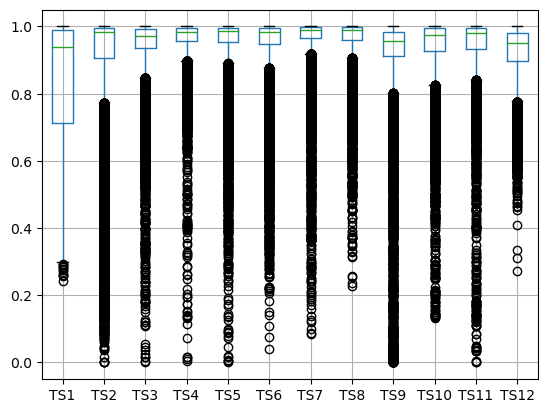

In [38]:
likelihood_data0_task1 = likelihood_norm(data_train[settings['T']-1:], reconst_data0_task1, sig_data0_task1)
likelihood_data0_task1.boxplot()

(0.8, 1.02)

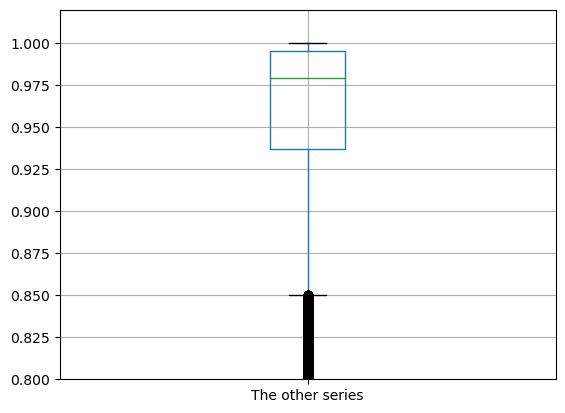

In [39]:
likelihood_data0_task1_rest = pd.concat([likelihood_data0_task1[col] for col in likelihood_data0_task1.columns[1:]], axis=0, ignore_index=True)
likelihood_data0_task1_rest = pd.DataFrame(likelihood_data0_task1_rest, columns=['The other series'])  # You can change 'New Column Name' to your desired column name

likelihood_data0_task1_rest.boxplot()
plt.ylim([0.80, 1.02])

<AxesSubplot:>

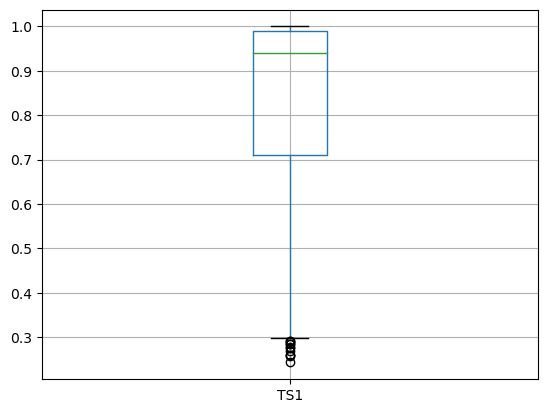

In [40]:
likelihood_data0_task1.boxplot(column=['TS1'])

### Data 1 Task 1

In [42]:
_, _, reconst_data1_task1, sig_data1_task1, _ = model_task1.predict(data_test_task1,
                                        False,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]+'_task1'
                                                    )

<AxesSubplot:>

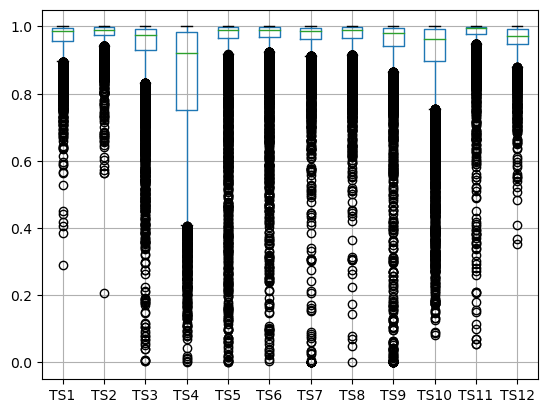

In [43]:
likelihood_data1_task1 = likelihood_norm(data_test_task1[settings['T']-1:], reconst_data1_task1, sig_data1_task1)
likelihood_data1_task1.boxplot()

(0.8, 1.02)

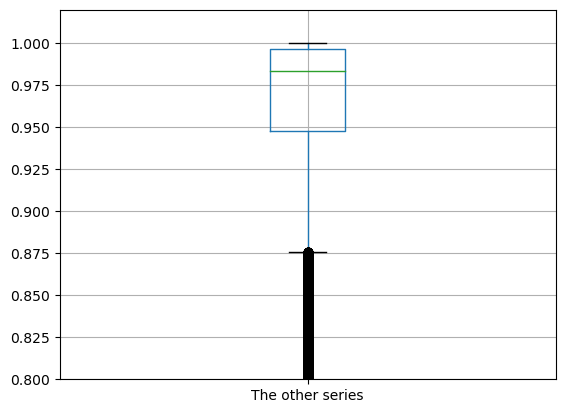

In [44]:
likelihood_data1_task1_rest = pd.concat([likelihood_data1_task1[col] for col in likelihood_data1_task1.columns[1:]], axis=0, ignore_index=True)
likelihood_data1_task1_rest = pd.DataFrame(likelihood_data1_task1_rest, columns=['The other series'])  # You can change 'New Column Name' to your desired column name

likelihood_data1_task1_rest.boxplot()
plt.ylim([0.80, 1.02])

([<matplotlib.axis.XTick at 0x7f126c5b2e80>,
 [Text(1, 0, 'data0_task1'), Text(2, 0, 'data1_task1')])

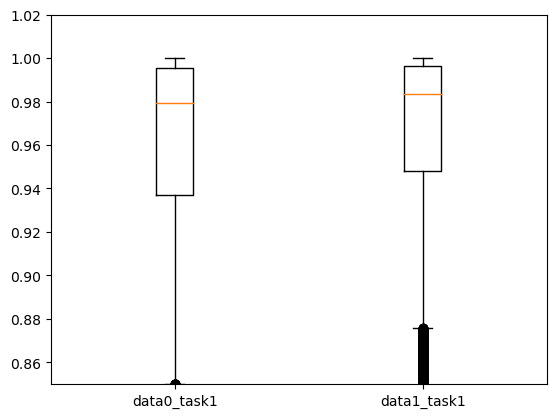

In [45]:
plt.boxplot([likelihood_data0_task1_rest.values[:,0], likelihood_data1_task1_rest.values[:,0]])
plt.ylim([0.85, 1.02])
plt.title('')
plt.xticks([1, 2], ['data0_task1', 'data1_task1'])

## Task 2

In [61]:
# Model initialization
model_task2 = DCVAE(
     settings['T'],
     settings['M'],
     settings['cnn_units'],
     settings['dil_rate'],
     settings['kernel'],
     settings['strs'],
     settings['batch_size'],
     settings['J'],
     settings['lr'],
     settings['lr_decay'],
     settings['decay_rate'],
     settings['decay_step'],
     settings['time_embedding'],
     settings['summary'],
     ) 

#model_task2.vae = keras.models.load_model(settings['model_name']+'_task1'+'_complete.h5',
#                                        custom_objects={'sampling': Sampling},
#                                        compile = True)
model_task2.vae = clone_model(model_task1.vae)

# Compilation
#opt = optimizers.Adam(learning_rate=settings['lr'])
opt = optimizers.SGD(learning_rate=0.1*settings['lr'], momentum=0.9)
model_task2.vae.compile(optimizer=opt)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_samples (InputLayer)      [(None, 128, 12)]    0                                            
__________________________________________________________________________________________________
dcnn_enc_0 (Conv1D)             (None, 128, 64)      1536        input_samples[0][0]              
__________________________________________________________________________________________________
dcnn_enc_1 (Conv1D)             (None, 128, 128)     16384       dcnn_enc_0[0][0]                 
__________________________________________________________________________________________________
dcnn_enc_2 (Conv1D)             (None, 128, 128)     32768       dcnn_enc_1[0][0]                 
____________________________________________________________________________________________

In [59]:
noise = np.random.normal(0, 1, (2*(data_train.shape[0]//10), 1, settings['J']))

#decoder = keras.models.load_model(settings['model_name']+'_decoder.h5',
#                                                custom_objects={'sampling': Sampling},
#                                                compile = True)


mu_gen_task1, log_var_gen_task1 = model_task1.decoder.predict(noise)

sig_gen_task1 = np.sqrt(np.exp(log_var_gen_task1))
noise2gen = np.random.normal(0, 1, (mu_gen_task1.shape[0], settings['T'], settings['M']))
X_gen_task1 = mu_gen_task1 + noise2gen*(sig_gen_task1)
X_gen_task1 = np.where(X_gen_task1 > 0, X_gen_task1, 0)   

In [62]:
model_task2.fit(data_train_task2,
    settings['val_percent'],
    settings['epochs'],
    settings['model_name']+'_GR_task2',
    settings['save_best_model'],
    False,
    X_gen_task1)

Epoch 1/200
524/524 [==============================] - 10s 16ms/step - loss: 4.6401 - reconst: 1.8079 - kl: 0.3108 - val_loss: 1.2606 - val_reconst: 1.0217 - val_kl: 0.2389
Epoch 2/200
524/524 [==============================] - 8s 15ms/step - loss: 1.1231 - reconst: 0.8200 - kl: 0.2172 - val_loss: 0.8671 - val_reconst: 0.6665 - val_kl: 0.2006
Epoch 3/200
524/524 [==============================] - 8s 15ms/step - loss: 0.7900 - reconst: 0.5402 - kl: 0.1927 - val_loss: 0.6116 - val_reconst: 0.4270 - val_kl: 0.1846
Epoch 4/200
524/524 [==============================] - 8s 15ms/step - loss: 0.5721 - reconst: 0.3438 - kl: 0.1800 - val_loss: 0.4439 - val_reconst: 0.2693 - val_kl: 0.1746
Epoch 5/200
524/524 [==============================] - 8s 15ms/step - loss: 0.4202 - reconst: 0.2200 - kl: 0.1713 - val_loss: 0.3345 - val_reconst: 0.1675 - val_kl: 0.1671
Epoch 6/200
524/524 [==============================] - 8s 15ms/step - loss: 0.3105 - reconst: 0.1301 - kl: 0.1645 - val_loss: 0.2540 - val_

### Data 0 Task 2

In [63]:
_, _, reconst_data0_task2, sig_data0_task2, _ = model_task2.predict(data_train,
                                        False,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]+'_task2'
                                                    )

<AxesSubplot:>

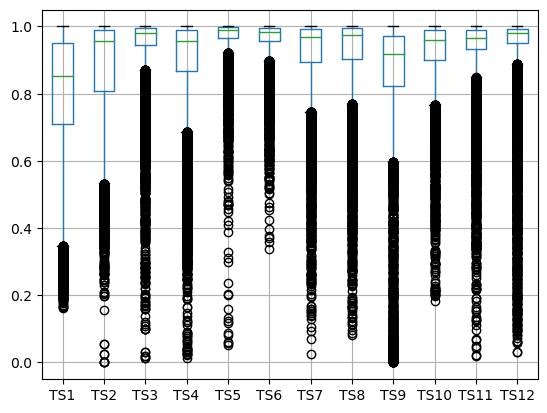

In [64]:
likelihood_data0_task2 = likelihood_norm(data_train[settings['T']-1:], reconst_data0_task2, sig_data0_task2)
likelihood_data0_task2.boxplot()

(0.8, 1.02)

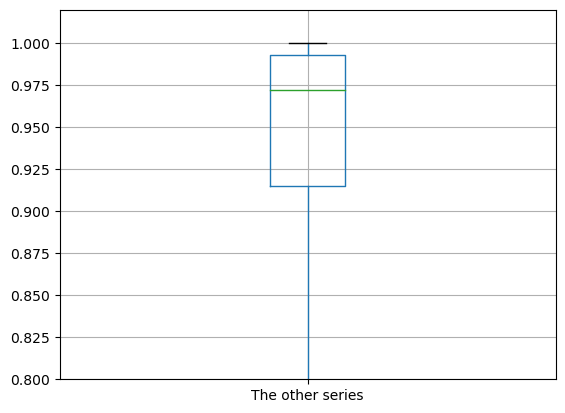

In [65]:
likelihood_data0_task2_rest = pd.concat([likelihood_data0_task2[col] for col in likelihood_data0_task2.columns[1:]], axis=0, ignore_index=True)
likelihood_data0_task2_rest = pd.DataFrame(likelihood_data0_task2_rest, columns=['The other series'])  # You can change 'New Column Name' to your desired column name

likelihood_data0_task2_rest.boxplot()
plt.ylim([0.80, 1.02])

### Data 1 Task 2

In [66]:
_, _, reconst_data1_task2, sig_data1_task2, _ = model_task2.predict(data_test_task1,
                                        False,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]+'_task2'
                                                    )

<AxesSubplot:>

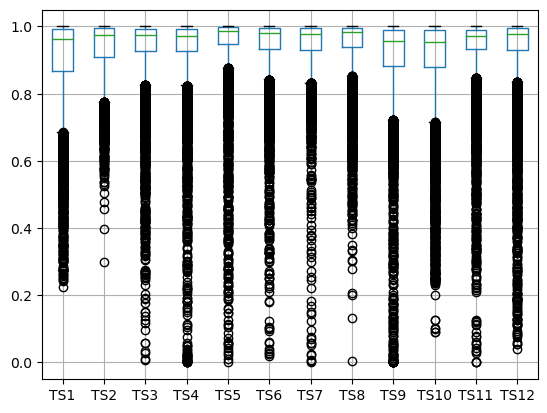

In [67]:
likelihood_data1_task2 = likelihood_norm(data_test_task1[settings['T']-1:], reconst_data1_task2, sig_data1_task2)
likelihood_data1_task2.boxplot()

(0.8, 1.02)

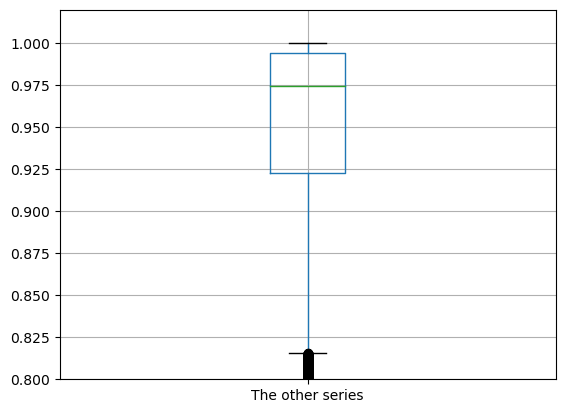

In [68]:
likelihood_data1_task2_rest = pd.concat([likelihood_data1_task2[col] for col in likelihood_data1_task2.columns[1:]], axis=0, ignore_index=True)
likelihood_data1_task2_rest = pd.DataFrame(likelihood_data1_task2_rest, columns=['The other series'])  # You can change 'New Column Name' to your desired column name

likelihood_data1_task2_rest.boxplot()
plt.ylim([0.80, 1.02])

### Data 2 Task 2

In [69]:
_, _, reconst_data2_task2, sig_data2_task2, _ = model_task2.predict(data_test_task2,
                                        False,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]+'_task2'
                                                    )

<AxesSubplot:>

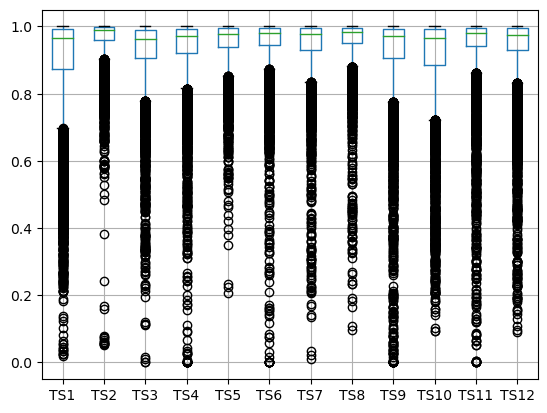

In [70]:
likelihood_data2_task2 = likelihood_norm(data_test_task2[settings['T']-1:], reconst_data2_task2, sig_data2_task2)
likelihood_data2_task2.boxplot()

(0.8, 1.02)

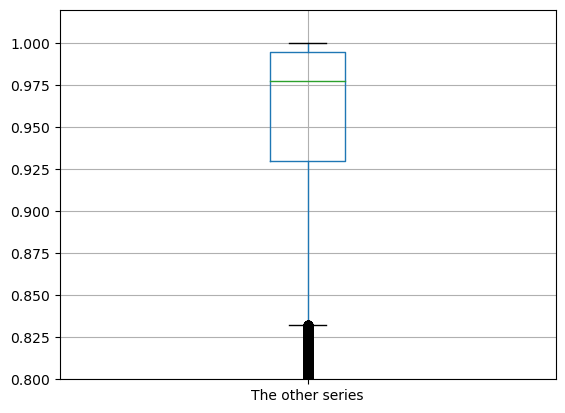

In [71]:
likelihood_data2_task2_rest = pd.concat([likelihood_data2_task2[col] for col in likelihood_data2_task2.columns[1:]], axis=0, ignore_index=True)
likelihood_data2_task2_rest = pd.DataFrame(likelihood_data2_task2_rest, columns=['The other series'])  # You can change 'New Column Name' to your desired column name

likelihood_data2_task2_rest.boxplot()
plt.ylim([0.80, 1.02])

([<matplotlib.axis.XTick at 0x7f0f898367f0>,
 [Text(1, 0, 'data0_task2'),
  Text(2, 0, 'data1_task2'),
  Text(3, 0, 'data2_task2')])

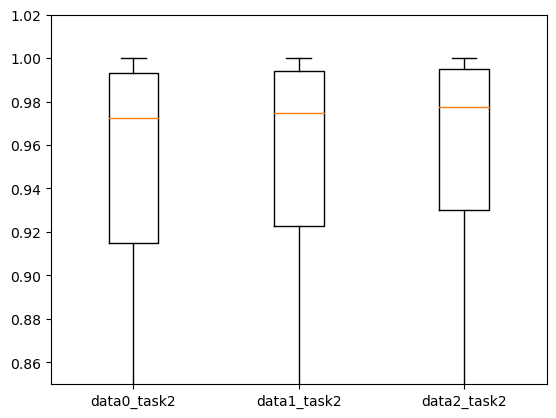

In [72]:
plt.boxplot([likelihood_data0_task2_rest.values[:,0], likelihood_data1_task2_rest.values[:,0], likelihood_data2_task2_rest.values[:,0]])
plt.ylim([0.85, 1.02])
plt.title('')
plt.xticks([1, 2, 3], ['data0_task2', 'data1_task2', 'data2_task2'])

([<matplotlib.axis.XTick at 0x7f0f8155e9a0>,
 [Text(1, 0, 'data0_task2'),
  Text(2, 0, 'data1_task2'),
  Text(3, 0, 'data2_task2')])

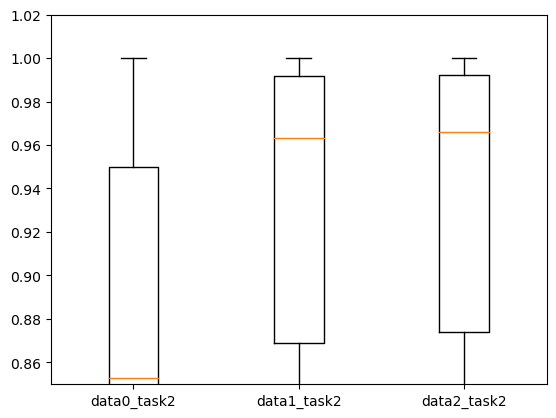

In [77]:
plt.boxplot([likelihood_data0_task2['TS1'].values, likelihood_data1_task2['TS1'].values, likelihood_data2_task2['TS1'].values])
plt.ylim([0.85, 1.02])
plt.title('')
plt.xticks([1, 2, 3], ['data0_task2', 'data1_task2', 'data2_task2'])

## Task 3

In [96]:
# Model initialization
model_task3 = DCVAE(
    settings['T'],
    settings['M'],
    settings['cnn_units'],
    settings['dil_rate'],
    settings['kernel'],
    settings['strs'],
    settings['batch_size'],
    settings['J'],
    settings['lr'],
    settings['lr_decay'],
    settings['decay_rate'],
    settings['decay_step'],
    settings['time_embedding'],
    settings['summary'],
    ) 

#model_task3.vae = keras.models.load_model(settings['model_name']+'_task2'+'_complete.h5',
#                                        custom_objects={'sampling': Sampling},
#                                        compile = True)

model_task3.vae = clone_model(model_task2.vae)


# Compilation
#opt = optimizers.Adam(learning_rate=settings['lr'])
opt = optimizers.SGD(learning_rate=0.1*settings['lr'], momentum=0.9)
model_task3.vae.compile(optimizer=opt)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_samples (InputLayer)      [(None, 128, 12)]    0                                            
__________________________________________________________________________________________________
dcnn_enc_0 (Conv1D)             (None, 128, 64)      1536        input_samples[0][0]              
__________________________________________________________________________________________________
dcnn_enc_1 (Conv1D)             (None, 128, 128)     16384       dcnn_enc_0[0][0]                 
__________________________________________________________________________________________________
dcnn_enc_2 (Conv1D)             (None, 128, 128)     32768       dcnn_enc_1[0][0]                 
____________________________________________________________________________________________

In [97]:
noise = np.random.normal(0, 1, (2*(data_train.shape[0]//10), 1, settings['J']))

#decoder = keras.models.load_model(settings['model_name']+'_decoder.h5',
#                                                custom_objects={'sampling': Sampling},
#                                                compile = True)


mu_gen_task2, log_var_gen_task2 = model_task2.decoder.predict(noise)

sig_gen_task2 = np.sqrt(np.exp(log_var_gen_task2))
noise2gen = np.random.normal(0, 1, (mu_gen_task2.shape[0], settings['T'], settings['M']))
X_gen_task2 = mu_gen_task2 + noise2gen*(sig_gen_task2)
X_gen_task2 = np.where(X_gen_task2 > 0, X_gen_task2, 0)   

In [98]:
model_task3.fit(data_train_task3,
    settings['val_percent'],
    settings['epochs'],
    settings['model_name']+'_GR_task3',
    settings['save_best_model'],
    False,
    X_gen_task2)

Epoch 1/200
531/531 [==============================] - 9s 15ms/step - loss: 3.1017 - reconst: 1.4359 - kl: 0.2893 - val_loss: 1.0970 - val_reconst: 0.8698 - val_kl: 0.2272
Epoch 2/200
531/531 [==============================] - 8s 15ms/step - loss: 1.0059 - reconst: 0.6877 - kl: 0.2174 - val_loss: 0.7153 - val_reconst: 0.5177 - val_kl: 0.1976
Epoch 3/200
531/531 [==============================] - 8s 15ms/step - loss: 0.6786 - reconst: 0.4304 - kl: 0.1971 - val_loss: 0.5165 - val_reconst: 0.3334 - val_kl: 0.1832
Epoch 4/200
531/531 [==============================] - 8s 15ms/step - loss: 0.5026 - reconst: 0.2901 - kl: 0.1850 - val_loss: 0.3939 - val_reconst: 0.2208 - val_kl: 0.1731
Epoch 5/200
531/531 [==============================] - 8s 15ms/step - loss: 0.3889 - reconst: 0.1968 - kl: 0.1759 - val_loss: 0.3072 - val_reconst: 0.1418 - val_kl: 0.1653
Epoch 6/200
531/531 [==============================] - 8s 15ms/step - loss: 0.3149 - reconst: 0.1258 - kl: 0.1686 - val_loss: 0.2435 - val_r

### Data 0 Task 3

In [116]:
_, _, reconst_data0_task3, sig_data0_task3, _ = model_task3.predict(data_train,
                                        False,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]+'_task3'
                                                    )

<AxesSubplot:>

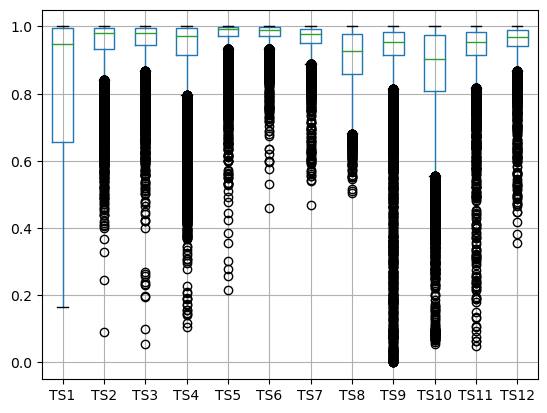

In [117]:
likelihood_data0_task3 = likelihood_norm(data_train[settings['T']-1:], reconst_data0_task3, sig_data0_task3)
likelihood_data0_task3.boxplot()

(0.8, 1.02)

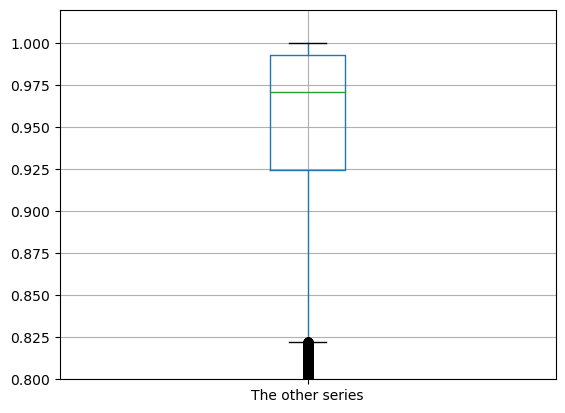

In [118]:
likelihood_data0_task3_rest = pd.concat([likelihood_data0_task3[col] for col in likelihood_data0_task3.columns[1:]], axis=0, ignore_index=True)
likelihood_data0_task3_rest = pd.DataFrame(likelihood_data0_task3_rest, columns=['The other series'])  # You can change 'New Column Name' to your desired column name

likelihood_data0_task3_rest.boxplot()
plt.ylim([0.80, 1.02])

### Data 1 Task 3

In [119]:
_, _, reconst_data1_task3, sig_data1_task3, _ = model_task3.predict(data_test_task1,
                                        False,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]+'_task3'
                                                    )

<AxesSubplot:>

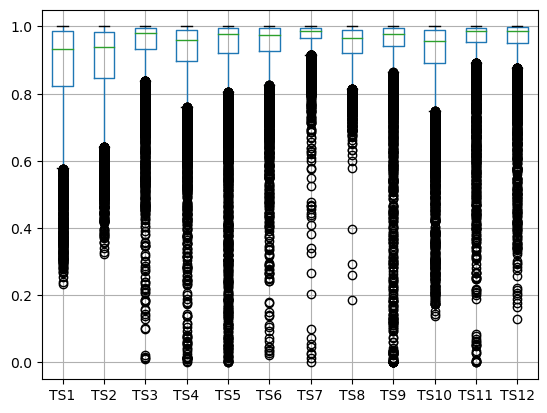

In [120]:
likelihood_data1_task3 = likelihood_norm(data_test_task1[settings['T']-1:], reconst_data1_task3, sig_data1_task3)
likelihood_data1_task3.boxplot()

(0.8, 1.02)

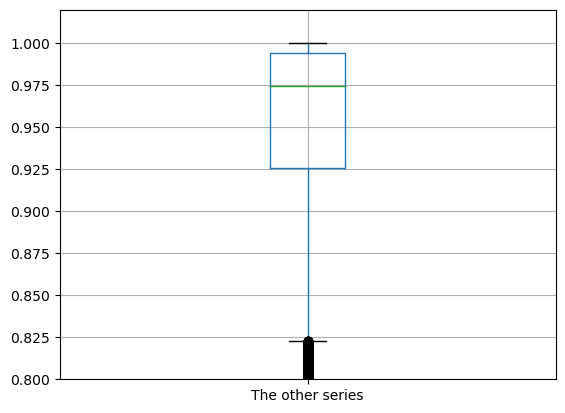

In [121]:
likelihood_data1_task3_rest = pd.concat([likelihood_data1_task3[col] for col in likelihood_data1_task3.columns[1:]], axis=0, ignore_index=True)
likelihood_data1_task3_rest = pd.DataFrame(likelihood_data1_task3_rest, columns=['The other series'])  # You can change 'New Column Name' to your desired column name

likelihood_data1_task3_rest.boxplot()
plt.ylim([0.80, 1.02])

### Data 2 Task 3

In [122]:
_, _, reconst_data2_task3, sig_data2_task3, _ = model_task3.predict(data_test_task2,
                                        False,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]+'_task3'
                                                    )

<AxesSubplot:>

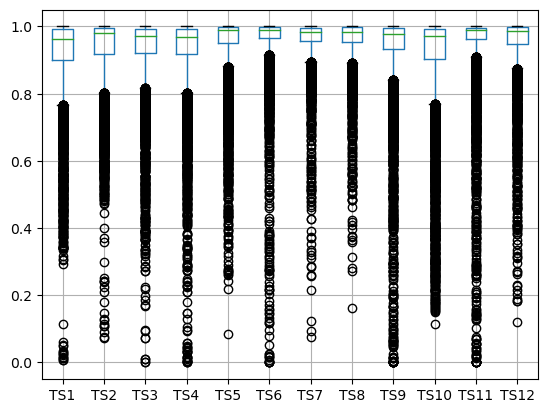

In [123]:
likelihood_data2_task3 = likelihood_norm(data_test_task2[settings['T']-1:], reconst_data2_task3, sig_data2_task3)
likelihood_data2_task3.boxplot()

(0.8, 1.02)

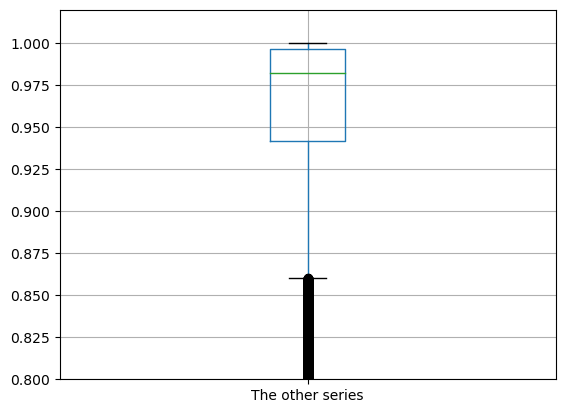

In [124]:
likelihood_data2_task3_rest = pd.concat([likelihood_data2_task3[col] for col in likelihood_data2_task3.columns[1:]], axis=0, ignore_index=True)
likelihood_data2_task3_rest = pd.DataFrame(likelihood_data2_task3_rest, columns=['The other series'])  # You can change 'New Column Name' to your desired column name

likelihood_data2_task3_rest.boxplot()
plt.ylim([0.80, 1.02])

### Data 3 Task 3

In [125]:
_, _, reconst_data3_task3, sig_data3_task3, _ = model_task3.predict(data_test_task3,
                                        False,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]+'_task3'
                                                    )

<AxesSubplot:>

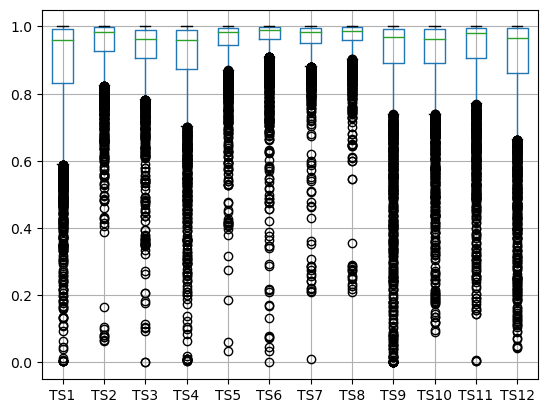

In [126]:
likelihood_data3_task3 = likelihood_norm(data_test_task3[settings['T']-1:], reconst_data3_task3, sig_data3_task3)
likelihood_data3_task3.boxplot()

(0.8, 1.02)

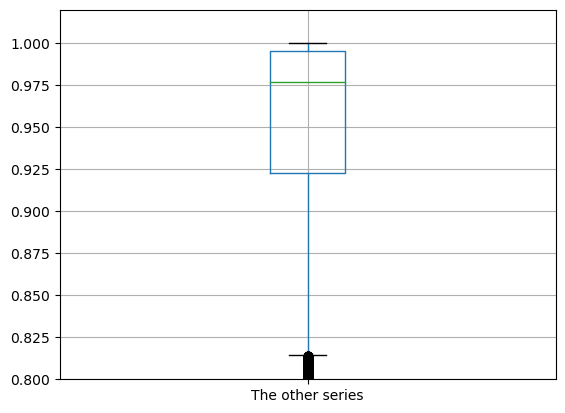

In [127]:
likelihood_data3_task3_rest = pd.concat([likelihood_data3_task3[col] for col in likelihood_data3_task3.columns[1:]], axis=0, ignore_index=True)
likelihood_data3_task3_rest = pd.DataFrame(likelihood_data3_task3_rest, columns=['The other series'])  # You can change 'New Column Name' to your desired column name

likelihood_data3_task3_rest.boxplot()
plt.ylim([0.80, 1.02])

([<matplotlib.axis.XTick at 0x7f0f3f01de50>,
 [Text(1, 0, 'data0_task3'),
  Text(2, 0, 'data1_task3'),
  Text(3, 0, 'data2_task3'),
  Text(4, 0, 'data3_task3')])

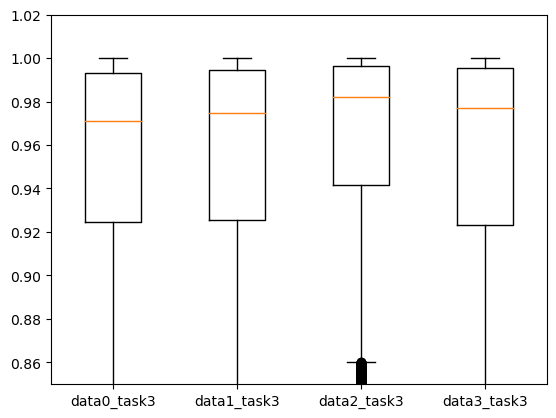

In [128]:
plt.boxplot([likelihood_data0_task3_rest.values[:,0], likelihood_data1_task3_rest.values[:,0], likelihood_data2_task3_rest.values[:,0], likelihood_data3_task3_rest.values[:,0]])
plt.ylim([0.85, 1.02])
plt.title('')
plt.xticks([1, 2, 3, 4], ['data0_task3', 'data1_task3', 'data2_task3', 'data3_task3'])

([<matplotlib.axis.XTick at 0x7f0f3efc0580>,
 [Text(1, 0, 'data0_task3'),
  Text(2, 0, 'data1_task3'),
  Text(3, 0, 'data2_task3'),
  Text(4, 0, 'data3_task3')])

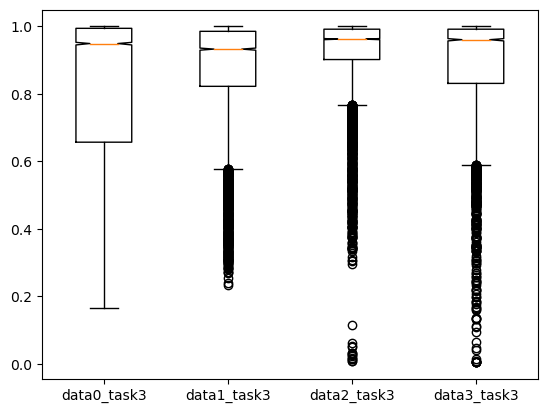

In [129]:
plt.boxplot([likelihood_data0_task3['TS1'].values, likelihood_data1_task3['TS1'].values, likelihood_data2_task3['TS1'].values, likelihood_data3_task3['TS1'].values],
 notch=True,
 bootstrap=5000)
plt.title('')
plt.xticks([1, 2, 3, 4], ['data0_task3', 'data1_task3', 'data2_task3', 'data3_task3'])

In [130]:
likelihood_data0_task3['TS1'].shape

(17441,)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0f39966c70>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0f39971250>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0f399669a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f0f399717f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f0f39971ac0>],
 'means': []}

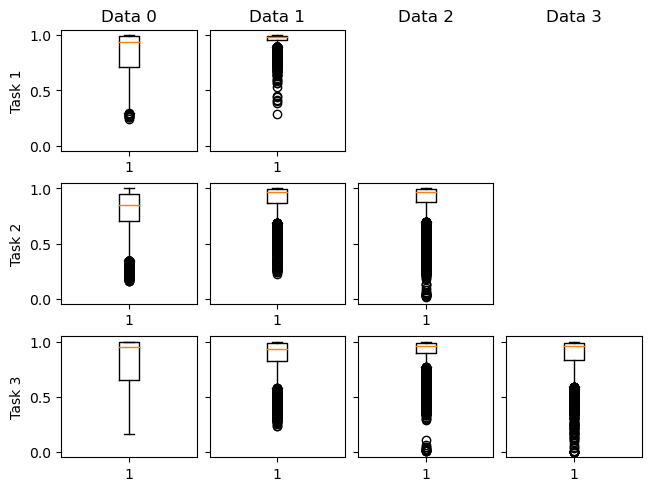

In [131]:
#define number of rows and columns for subplots
nrow=3
ncol=4

fig, axes = plt.subplots(nrow, ncol, constrained_layout=True, sharey=True)

axes[0,0].boxplot(likelihood_data0_task1['TS1'].values)
axes[0,0].set_title('Data 0')
axes[0,0].set_ylabel('Task 1')
axes[0,1].boxplot(likelihood_data1_task1['TS1'].values)
axes[0,1].set_title('Data 1')
axes[0,2].axis('off')
axes[0,2].set_title('Data 2')
axes[0,3].axis('off')
axes[0,3].set_title('Data 3')


axes[1,0].boxplot(likelihood_data0_task2['TS1'].values)
axes[1,0].set_ylabel('Task 2')
axes[1,1].boxplot(likelihood_data1_task2['TS1'].values)
axes[1,2].boxplot(likelihood_data2_task2['TS1'].values)
axes[1,3].axis('off')

axes[2,0].boxplot(likelihood_data0_task3['TS1'].values)
axes[2,0].set_ylabel('Task 3')
axes[2,1].boxplot(likelihood_data1_task3['TS1'].values)
axes[2,2].boxplot(likelihood_data2_task3['TS1'].values)
axes[2,3].boxplot(likelihood_data3_task3['TS1'].values)


(0.8, 1.02)

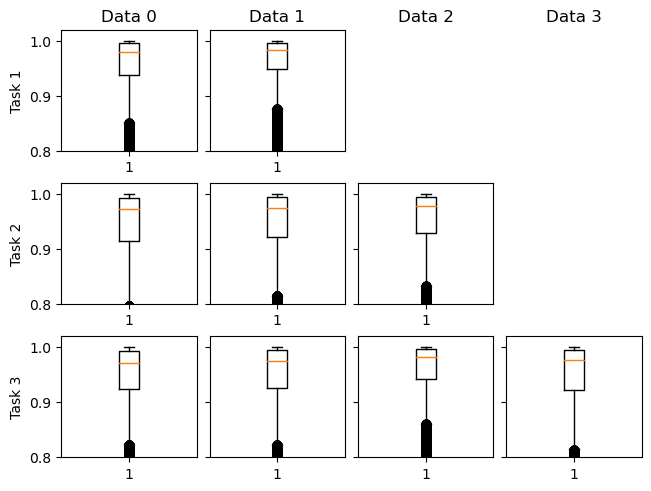

In [132]:
#define number of rows and columns for subplots
nrow=3
ncol=4

fig, axes = plt.subplots(nrow, ncol, constrained_layout=True, sharey=True)

axes[0,0].boxplot(likelihood_data0_task1_rest.values[:,0])
axes[0,0].set_title('Data 0')
axes[0,0].set_ylabel('Task 1')
axes[0,1].boxplot(likelihood_data1_task1_rest.values[:,0])
axes[0,1].set_title('Data 1')
axes[0,2].axis('off')
axes[0,2].set_title('Data 2')
axes[0,3].axis('off')
axes[0,3].set_title('Data 3')


axes[1,0].boxplot(likelihood_data0_task2_rest.values[:,0])
axes[1,0].set_ylabel('Task 2')
axes[1,1].boxplot(likelihood_data1_task2_rest.values[:,0])
axes[1,2].boxplot(likelihood_data2_task2_rest.values[:,0])
axes[1,3].axis('off')

axes[2,0].boxplot(likelihood_data0_task3_rest.values[:,0])
axes[2,0].set_ylabel('Task 3')
axes[2,1].boxplot(likelihood_data1_task3_rest.values[:,0])
axes[2,2].boxplot(likelihood_data2_task3_rest.values[:,0])
axes[2,3].boxplot(likelihood_data3_task3_rest.values[:,0])

plt.ylim([0.80, 1.02])
